In [29]:
import os
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [26]:
dataset_path = "../Datasets/HousingData.csv"

random_state = 42
wandb_log = False
os.environ["WANDB_SILENT"] = "true"

hyperparameter_tuning = False

In [3]:
lr = 0.01
max_epochs = 1000
optimizer = 'bgd'
activation = 'sigmoid'
hidden_layers = [8,]
batch_size = 32

In [4]:
def wandb_init(lr, max_epochs, optimizer, activation, hidden_layers, batch_size):
    if wandb_log:
        config = {
            "lr": lr, 
            "model_type": "MLP_Regression",
            "optimizer": optimizer, # SGC/BGD/MBGD
            "criterion": "mse",
            "num_epochs": max_epochs,
            "batch_size": batch_size,
            "hidden_layers": hidden_layers,
            "activation": activation,
            "wandb_run_name": "bhav" ,
            "tags": ["P3",]
        }

        wandb.init(entity = "bhavberi",   # wandb username. (NOT REQUIRED ARG. ANYMORE, it fetches from initial login)
                project = "SMAI",        # wandb project name. New project will be created if given project is missing.
                config = config         # Config dict
                )
        wandb.run.name = f"P3_{config['optimizer']}_{config['activation']}_{len(config['hidden_layers'])}_{config['lr']}_{config['batch_size']}_{config['num_epochs']}"
        print(wandb.run.name)

def wandb_finish():
    if wandb_log:
        wandb.finish()

In [5]:
dataset = pd.read_csv(dataset_path)
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [6]:
dataset.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
X = dataset.drop(columns=['MEDV']).to_numpy()
y = dataset['MEDV'].to_numpy()

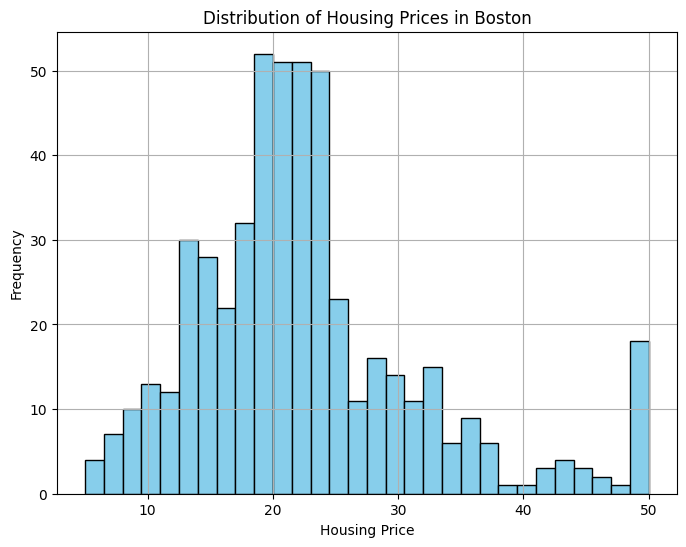

In [8]:
# plt.figure(figsize=(8, 6))
# plt.hist(y, bins=30, color='skyblue', edgecolor='black')
# plt.title('Distribution of Housing Prices in Boston')
# plt.xlabel('Housing Price')
# plt.ylabel('Frequency')
# plt.grid(True)

# plt.show()

In [9]:
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
# To fill in data

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_validation.shape, y_validation.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (404, 13) (404,)
Validation set shape: (51, 13) (51,)
Test set shape: (51, 13) (51,)


In [11]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_validation_std = scaler.transform(X_validation)
X_test_std = scaler.transform(X_test)

In [50]:
class MLP_Regression:
    def __init__(self, input_size, hidden_layers, output_size, learning_rate=0.01, activation='sigmoid', optimizer='sgd', print_every=10, wandb_log=False):
        assert activation.lower() in ['sigmoid', 'relu', 'tanh'], "Activation function must be either 'sigmoid', 'relu' or 'tanh'"
        assert optimizer.lower() in ['sgd', 'bgd', 'mbgd'], "Optimizer must be either 'sgd', 'bgd' or 'mbgd'"
        assert input_size > 0, "Input size must be greater than 0"
        assert output_size > 0, "Output size must be greater than 0"
        assert learning_rate > 0, "Learning rate must be greater than 0"
        assert type(hidden_layers) == list and len(hidden_layers) > 0, "Hidden layers must be a list of size greater than 0"

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.activation_func = self._get_activation_func(activation)
        self.optimizer_func = self._get_optimizer_func(optimizer)
        self.weights, self.biases = self._initialize_weights_and_biases()

        self.wandb_log = wandb_log
        self.print_every = print_every

    # Activation functions
    def _get_activation_func(self, activation):
        if activation == "sigmoid":
            return self._sigmoid
        elif activation == "tanh":
            return self._tanh
        elif activation == "relu":
            return self._relu
        else:
            raise ValueError(f"Activation function '{activation}' not supported.")

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _tanh(self, x):
        return np.tanh(x)

    def _relu(self, x):
        return np.maximum(0, x)

    # Activation derivative
    def _activation_derivative(self, Z):
        if self.activation_func == self._sigmoid:
            return self._sigmoid_derivative(Z)
        elif self.activation_func == self._tanh:
            return self._tanh_derivative(Z)
        elif self.activation_func == self._relu:
            return self._relu_derivative(Z)
        else:
            raise ValueError(
                f"Activation function '{self.activation_func}' not supported."
            )

    def _sigmoid_derivative(self, Z):
        return self._sigmoid(Z) * (1 - self._sigmoid(Z))

    def _tanh_derivative(self, Z):
        return 1 - np.square(self._tanh(Z))

    def _relu_derivative(self, Z):
        return np.where(Z > 0, 1, 0)

    # Optimizers
    def _get_optimizer_func(self, optimizer):
        if optimizer == "sgd":
            return self._sgd
        elif optimizer == "bgd":
            return self._bgd
        elif optimizer == "mbgd":
            return self._mbgd
        else:
            raise ValueError(f"Optimizer '{optimizer}' not supported.")

    def _sgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dW"][i]
            self.biases[i] -= self.learning_rate * grads["db"][i]

    def _bgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads["dW"][i] / self.input_size
            self.biases[i] -= self.learning_rate * grads["db"][i] / self.input_size

    def _mbgd(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= (
                self.learning_rate * grads["dW"][i] / grads["dW"][i].shape[1]
            )
            self.biases[i] -= (
                self.learning_rate * grads["db"][i] / grads["db"][i].shape[1]
            )

    # Initialize weights and biases
    def _initialize_weights_and_biases(self):
        num_layers = len(self.hidden_layers)
        weights = []
        biases = []

        if num_layers == 0:
            w = np.random.randn(self.input_size, self.output_size)
            b = np.zeros((1, self.output_size))
            weights.append(w)
            biases.append(b)
            return weights, biases

        # Using Github Copilot
        for i in range(num_layers + 1):
            if i == 0:
                w = 0.01 * np.random.randn(self.input_size, self.hidden_layers[0])
            elif i == num_layers:
                w = 0.01 * np.random.randn(self.hidden_layers[-1], self.output_size)
            else:
                w = 0.01 * np.random.randn(
                    self.hidden_layers[i - 1], self.hidden_layers[i]
                )

            b = np.zeros((1, w.shape[1]))
            weights.append(w)
            biases.append(b)

        return weights, biases

    # Forward propagation
    def _forward_propagation(self, X):
        num_layers = len(self.weights)
        A = X
        caches = []

        for i in range(num_layers):
            W = self.weights[i]
            b = self.biases[i]

            Z = np.dot(A, W) + b

            if Z.shape[1] == 1:
                Z = Z.reshape(-1)
            caches.append((A, W, b, Z))
            # print("Forward", A.shape, W.shape, b.shape, Z.shape)

            A = self.activation_func(Z)

        if len(A.shape) == 1:
            A = A.reshape(-1)
        return A, caches

    # Backward propagation
    def _backward_propagation(self, A, Y, caches):
        num_samples = A.shape[0]
        num_layers = len(self.weights)
        grads = {"dW": [], "db": []}

        delta = A - Y
        # print(delta.shape, A.shape, Y.shape)

        for i in reversed(range(num_layers)):
            A, W, _, Z = caches[i]
            # print("A", A.shape, "W", W.shape, "Z", Z.shape)

            dZ = np.multiply(delta, self._activation_derivative(Z))
            if dZ.ndim == 1:
                dZ = dZ.reshape((dZ.shape[0], 1))
            # print("dZ", dZ.shape)
            dW = np.dot(A.T, dZ)
            # print("dW", dW.shape)
            db = np.sum(dZ, axis=0, keepdims=True)
            # print("db", db.shape)

            delta = np.dot(dZ, W.T)
            # print("delta", delta.shape)

            if len(dW.shape) == 1:
                dW = dW.reshape(-1, 1)

            grads["dW"].append(dW)
            grads["db"].append(db)

        grads["dW"].reverse()
        grads["db"].reverse()

        return grads

    # Calculate cost
    def _calculate_cost(self, A, Y):
        # print(A.shape, Y.shape)
        mse = np.mean(np.square(A - Y))
        rmse = np.sqrt(mse)
        r_squred = 1 - (np.sum(np.square(Y - A)) / np.sum(np.square(Y - np.mean(Y))))
        return mse, rmse, r_squred

    # Predict
    def predict(self, X):
        A, _ = self._forward_propagation(X)
        return A
    
    # Evaluate
    def evaluate(self, X, Y):
        A = self.predict(X)
        mse, rmse, r_squared = self._calculate_cost(A, Y)
        return mse, rmse, r_squared

    # Train the model
    def train(
        self, X, Y, max_epochs=10, batch_size=32, X_validation=None, y_validation=None
    ):
        num_samples = X.shape[0]
        costs = []

        for i in range(max_epochs):
            if self.optimizer == "bgd":
                batch_size = num_samples
                num_batches = 1
            elif self.optimizer == "sgd":
                batch_size = 1
                num_batches = num_samples
            elif self.optimizer == "mbgd":
                num_batches = num_samples // batch_size
            else:
                raise ValueError(f"Optimizer '{self.optimizer}' not supported.")

            for j in range(num_batches):
                start = j * batch_size
                end = start + batch_size

                A, caches = self._forward_propagation(X[start:end])
                grads = self._backward_propagation(A, Y[start:end], caches)
                self.optimizer_func(grads)

            A = self.predict(X)
            mse, rmse, r_squared = self._calculate_cost(A, Y)
            costs.append(mse)

            data_to_log = {"epoch": i + 1, "train_loss": mse}

            # Calculate validation loss
            if X_validation is not None and y_validation is not None:
                A = self.predict(X_validation)
                val_loss_mse, val_loss_rmse, val_loss_r_squared = self._calculate_cost(A, y_validation)
                data_to_log["val_loss"] = val_loss_mse

            if self.wandb_log:
                wandb.log(data_to_log)

            if self.print_every and (i + 1) % self.print_every == 0:
                print(f"Cost after {i+1} epochs: {mse}")

        return costs

In [51]:
model = MLP_Regression(X_train_std.shape[1], hidden_layers, 1, learning_rate=0.001, activation="relu", optimizer="mbgd")
costs = model.train(X_train_std, y_train, max_epochs=100, batch_size=batch_size, X_validation=X_validation_std, y_validation=y_validation)

Cost after 10 epochs: 19.698749879548878
Cost after 20 epochs: 16.557903666103567
Cost after 30 epochs: 14.56211850701852
Cost after 40 epochs: 13.332479688206348
Cost after 50 epochs: 12.313574849265848
Cost after 60 epochs: 11.661011897596628
Cost after 70 epochs: 11.017753273562787
Cost after 80 epochs: 10.594313452696289
Cost after 90 epochs: 10.169950167299316
Cost after 100 epochs: 9.989003266184923


In [52]:
# plt.figure(figsize=(8, 6))
# plt.plot(costs)
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()

In [53]:
print(mean_absolute_error(y_test, model.predict(X_test_std)))

2.1763511523476295


In [54]:
if hyperparameter_tuning:
    for optimizer in ['sgd', 'bgd', 'mbgd']:
        for activation in ['sigmoid', 'relu', 'tanh']:
            for lr in [0.001, 0.01, 0.1]:
                max_epochs = 1000
                batch_size = 32
                wandb_init(lr, max_epochs, optimizer, activation, hidden_layers, batch_size)
                model = MLP_Regression(X_train_std.shape[1], hidden_layers, 1, learning_rate=lr, activation=activation, optimizer=optimizer, print_every=None, wandb_log=True)
                costs = model.train(X_train_std, y_train, max_epochs=max_epochs, batch_size=batch_size, X_validation=X_validation_std, y_validation=y_validation)
                mse, rmse, r_squared = model.evaluate(X_test_std, y_test)
                wandb.log({"test_loss": mse, "test_rmse": rmse, "test_r_squared": r_squared})
                wandb_finish()


In [55]:
wandb_data = pd.read_csv("../wandb_export_P3.csv")
print(wandb_data.head())

wandb_data.sort_values(by=["test_loss", "test_rmse", "test_r_squared"], ascending=True, inplace=True)
wandb_data.reset_index(drop=True, inplace=True)

                           Name activation     lr optimizer  batch_size  \
0   P3_bgd_relu_1_0.001_32_1000       relu  0.001       bgd          32   
1   P3_sgd_relu_1_0.001_32_1000       relu  0.001       sgd          32   
2  P3_mbgd_relu_1_0.001_32_1000       relu  0.001      mbgd          32   
3   P3_mbgd_relu_1_0.01_32_1000       relu  0.010      mbgd          32   
4    P3_sgd_relu_1_0.01_32_1000       relu  0.010       sgd          32   

   num_epochs hidden_layers  train_loss   val_loss  test_loss  test_rmse  \
0        1000           [8]    9.426676  19.699096  10.451521   3.232881   
1        1000           [8]    7.602558  20.720354   7.488175   2.736453   
2        1000           [8]    7.401104  23.469117   9.675291   3.110513   
3        1000           [8]   20.694094  26.590245  19.647841   4.432589   
4        1000           [8]   36.851673  30.856010  31.890613   5.647177   

   test_r_squared  
0        0.874008  
1        0.909731  
2        0.883365  
3        0.7

In [56]:
columns = ["Name", "test_loss", "test_rmse", "test_r_squared"]
print(wandb_data[columns])

                               Name   test_loss  test_rmse  test_r_squared
0       P3_sgd_relu_1_0.001_32_1000    7.488175   2.736453        0.909731
1      P3_mbgd_relu_1_0.001_32_1000    9.675291   3.110513        0.883365
2       P3_bgd_relu_1_0.001_32_1000   10.451521   3.232881        0.874008
3       P3_mbgd_relu_1_0.01_32_1000   19.647841   4.432589        0.763147
4        P3_sgd_relu_1_0.01_32_1000   31.890613   5.647177        0.615562
5         P3_sgd_relu_1_0.1_32_1000  220.656171  14.854500       -1.659987
6        P3_mbgd_tanh_1_0.1_32_1000  484.131176  22.002981       -4.836151
7         P3_bgd_tanh_1_0.1_32_1000  484.131176  22.002981       -4.836151
8     P3_mbgd_sigmoid_1_0.1_32_1000  484.131176  22.002981       -4.836151
9      P3_bgd_sigmoid_1_0.1_32_1000  484.131176  22.002981       -4.836151
10        P3_sgd_tanh_1_0.1_32_1000  484.131180  22.002981       -4.836151
11     P3_sgd_sigmoid_1_0.1_32_1000  484.131185  22.002981       -4.836152
12       P3_sgd_tanh_1_0.

In [57]:
print("Best Parameters for MLP Regression:")
print("Optimizer:", wandb_data.iloc[0]["optimizer"])
print("Activation:", wandb_data.iloc[0]["activation"])
print("Learning Rate:", wandb_data.iloc[0]["lr"])
print("Batch Size:", wandb_data.iloc[0]["batch_size"])
print("Epochs:", wandb_data.iloc[0]["num_epochs"])
print("Hidden Layers:", wandb_data.iloc[0]["hidden_layers"])

Best Parameters for MLP Regression:
Optimizer: sgd
Activation: relu
Learning Rate: 0.001
Batch Size: 32
Epochs: 1000
Hidden Layers: [8]


In [58]:
best_model = MLP_Regression(X_train_std.shape[1], hidden_layers, 1, learning_rate=wandb_data.iloc[0]["lr"], activation=wandb_data.iloc[0]["activation"], optimizer=wandb_data.iloc[0]["optimizer"], print_every=None, wandb_log=False)
costs = best_model.train(X_train_std, y_train, max_epochs=wandb_data.iloc[0]["num_epochs"], batch_size=wandb_data.iloc[0]["batch_size"], X_validation=X_validation_std, y_validation=y_validation)

mse, rmse, r_squared = best_model.evaluate(X_test_std, y_test)
print("Test Loss:", mse)
print("Test RMSE:", rmse)
print("Test R^2:", r_squared)

Test Loss: 6.413082090060536
Test RMSE: 2.532406383276692
Test R^2: 0.9226909564902691
